# Scikit-Learn Model


In [6]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix


# Load the dataset
df = pd.read_csv('../../data/output/eicu.csv')

# Convert 'age' to numeric, coercing errors to NaN
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Fill missing values for 'age' and 'admissionheight' with the median
df['age'] = df['age'].fillna(df['age'].median())
df['admissionheight'] = df['admissionheight'].fillna(df['admissionheight'].median())

# ---------------------------
# Encode FEATURES (one-hot) and TARGET (label-encode)
# ---------------------------

# Target as original labels first (string/categorical)
y_raw = df['diagnosis'].astype(str)

# Label-encode the target
le_y = LabelEncoder()
y = le_y.fit_transform(y_raw)

# One-hot encode feature categoricals (EXCLUDING the target)
categorical_feature_cols = ['gender', 'ethnicity', 'hospitaladmitsource']  # diagnosis excluded
df_features = df.drop(columns=['diagnosis'])  # remove target from features

X = pd.get_dummies(
    df_features,
    columns=categorical_feature_cols,
    drop_first=True,     # optional: avoids dummy trap; remove if you prefer full rank
    dummy_na=False,
    dtype='int8'
)

# Drop non-predictive ID columns if desired
cols_to_drop = [c for c in ['patientunitstayid'] if c in X.columns]
X = X.drop(columns=cols_to_drop)

# ---------------------------
# Train / Test split (stratify recommended for classification)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# XGBoost for multi-class
# ---------------------------
n_classes = len(le_y.classes_)
model = XGBClassifier(
    objective='multi:softprob',  # predicts class probabilities for multi-class
    num_class=n_classes,
    eval_metric='mlogloss',
    tree_method='hist',          # fast default; adjust depending on environment/GPU
    random_state=42
)

model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le_y.classes_)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)



Accuracy: 0.3790
Classification Report:
                     precision    recall  f1-score   support

       burns/trauma       1.00      0.10      0.18        10
     cardiovascular       0.45      0.72      0.56       126
          endocrine       0.44      0.55      0.49        22
   gastrointestinal       0.27      0.16      0.20        38
infectious diseases       0.00      0.00      0.00        14
         neurologic       0.06      0.03      0.04        35
              other       0.00      0.00      0.00        14
          pulmonary       0.29      0.22      0.25        59
              renal       0.67      0.18      0.29        11
         toxicology       0.67      0.29      0.40        14

           accuracy                           0.38       343
          macro avg       0.38      0.22      0.24       343
       weighted avg       0.36      0.38      0.34       343



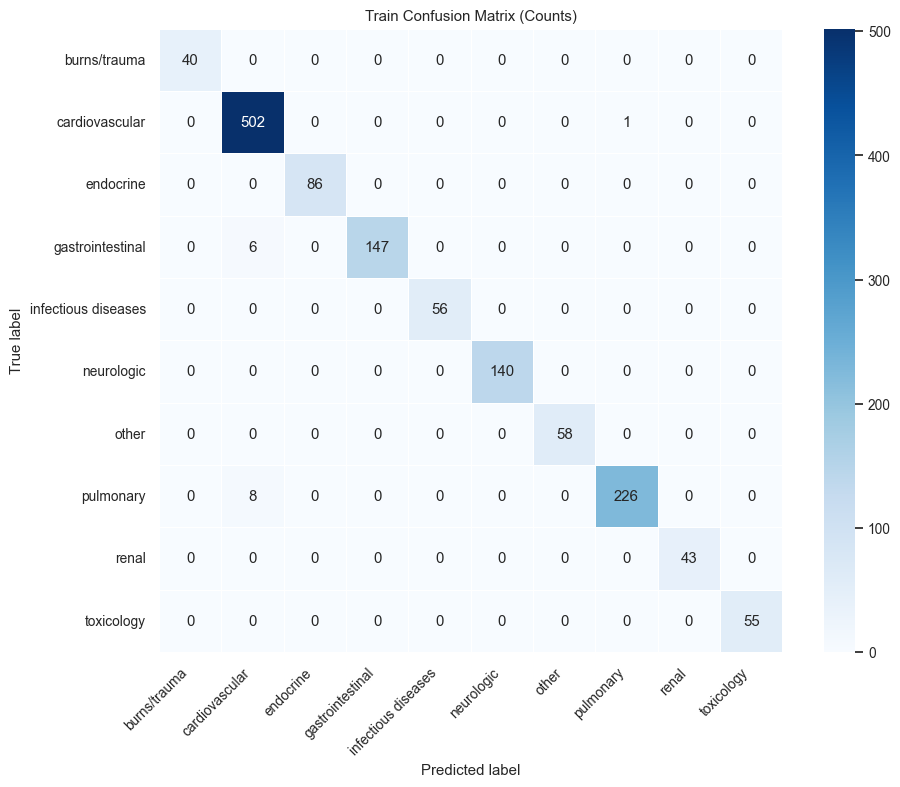

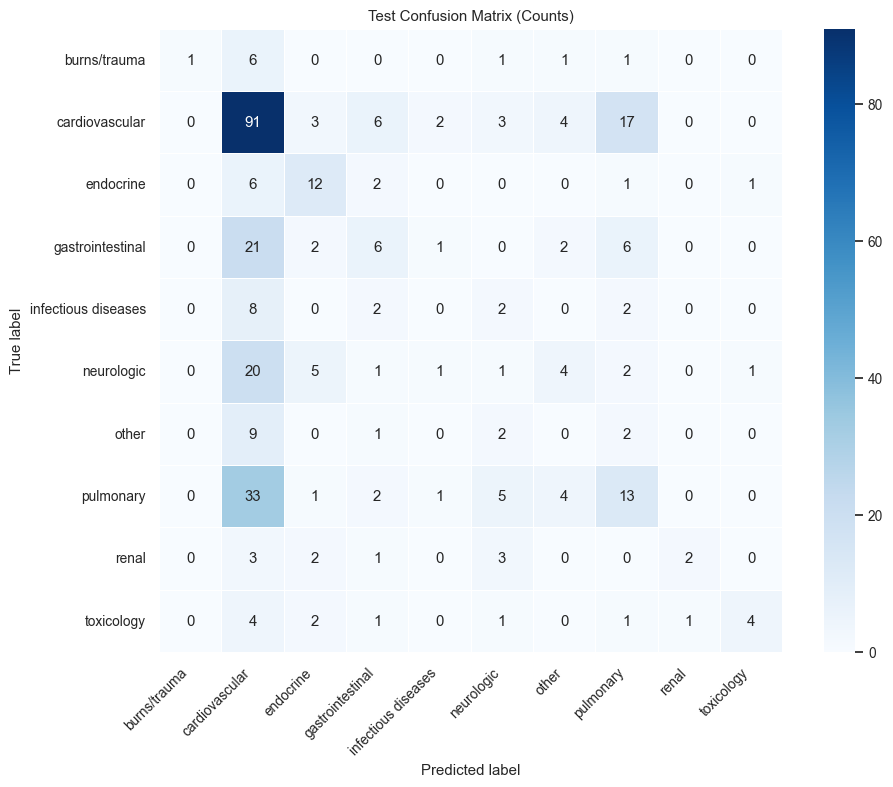

In [7]:

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

sns.set(style="whitegrid", font_scale=0.9)

def plot_confusion_matrix(y_true, y_pred, class_names, title="", normalize=None, figsize=(10, 8), cmap="Blues"):
    """
    normalize: None | 'true' | 'pred' | 'all'
        - None: raw counts
        - 'true': rows sum to 1 (per-actual-class recall-normalized)
        - 'pred': cols sum to 1 (per-predicted-class precision-normalized)
        - 'all': overall normalization
    """
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)), normalize=normalize)
    # If normalized, cm is float; if not, it’s int. Format differently for annotations.
    fmt = ".2f" if normalize else "d"
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(cm_df, annot=True, fmt=fmt, cmap=cmap, cbar=True,
                     linewidths=0.5, linecolor="white", square=True)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title if title else "Confusion Matrix")
    # Rotate x tick labels for readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_confusion_matrix(
    y_train, y_pred_train, class_names=le_y.classes_,
    title="Train Confusion Matrix (Counts)", normalize=None
)
plot_confusion_matrix(
    y_test, y_pred_test, class_names=le_y.classes_,
    title="Test Confusion Matrix (Counts)", normalize=None
)
